# **Restaurant Location Analysis**
##  *IBM Applied Data Science Capstone*
###  By: Luanluan Xu
###  July, 2019

## Table of contents
* [1.Data Colection and Cleaning](#data)
* [2.Exploratory Data Analysis](#analysis)
* [3.Results and Discussion](#results)
* [4.Conclusion](#conclusion)

## 1.Data Colection and Cleaning

In [1]:
import seaborn as sns
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
sns.set()
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### 1) Neighborhoods in New York City From Module 3 in this course
##### we can get 5 boroughs in NYC and 306 neighborhoods that exist in each borough as well as the the latitude and longitude coordinates of each neighborhood, I have saved it to dy_newyork.csv, let's read it.

In [71]:
df_ny=pd.read_csv('df_newyork.csv')
df_ny.head() 

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### 2) Restaurants in New York City 
##### Use the Foursquare API to explore the neighborhoods and get all the venues data. We only need the restaurants data, so I just filter the data that the venue category contains 'Restaurant'. 

Define Foursquare Credentials and Version

In [72]:
CLIENT_ID = 'UW0HTY0ADUCH2DDBK5KHRK0K23FRHANECFUKOFFCPEND4JX1' # your Foursquare ID
CLIENT_SECRET = 'TR3X4JSLKKMJKSPMKYC2QQWWT5Y2PRNF1UFBPCYVKRMBTTL1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UW0HTY0ADUCH2DDBK5KHRK0K23FRHANECFUKOFFCPEND4JX1
CLIENT_SECRET:TR3X4JSLKKMJKSPMKYC2QQWWT5Y2PRNF1UFBPCYVKRMBTTL1


In [73]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called *ny_venues*.

In [74]:
LIMIT=100
radius=500
ny_venues = getNearbyVenues(names=df_ny['Neighborhood'],
                                   latitudes=df_ny['Latitude'],
                                   longitudes=df_ny['Longitude']                                                             
                                  )


ny_venues.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Let's check the size of the resulting dataframe.

In [77]:
print("ny_venues' shape : ", ny_venues.shape)
ny_venues.head()

ny_venues' shape :  (10764, 7)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
Neighborhood,,,,,,,
Allerton,40.865788,-73.859319,White Castle,40.866065,-73.862307,Fast Food Restaurant,Bronx
Allerton,40.865788,-73.859319,Bronx Martial Arts Academy,40.865721,-73.857529,Martial Arts Dojo,Bronx
Allerton,40.865788,-73.859319,Domenick's Pizzeria,40.865576,-73.858124,Pizza Place,Bronx
Allerton,40.865788,-73.859319,Sal & Doms Bakery,40.865377,-73.855236,Dessert Shop,Bronx
Allerton,40.865788,-73.859319,Dunkin',40.865204,-73.859007,Donut Shop,Bronx


In this project, we want to do restaurants location analysis, so let's slice the original dataframe and create a new dataframe which only contains restaurants.

In [78]:
ny_venues=pd.read_csv('ny_venues.csv')

# join df_ny to get the colomn:'Borough'
ny_venues=ny_venues.set_index('Neighborhood').join(df_ny.set_index('Neighborhood'))
ny_venues=ny_venues.drop(['Latitude','Longitude'], axis=1)
print("ny_venues' shape : ", ny_venues.shape)

# slice the original dataframe and create a new dataframe of the '*Restaurant'.
df_res0=ny_venues[ny_venues['Venue Category'].str.contains("Restaurant")]

print("df_res0' shape : ", df_res0.shape)
df_res0.head()

ny_venues' shape :  (10764, 7)
df_res0' shape :  (2698, 7)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
Neighborhood,,,,,,,
Allerton,40.865788,-73.859319,White Castle,40.866065,-73.862307,Fast Food Restaurant,Bronx
Allerton,40.865788,-73.859319,Chef King,40.865561,-73.856752,Chinese Restaurant,Bronx
Allerton,40.865788,-73.859319,Internacional Restaurant & Deli,40.863809,-73.856640,Spanish Restaurant,Bronx
Annadale,40.538114,-74.178549,Il Sogno,40.541286,-74.178489,Restaurant,Staten Island
Annadale,40.538114,-74.178549,Diesel Bagels,40.540373,-74.177374,American Restaurant,Staten Island


### 3) Population density by Neighborhoods 
##### A Wikipedia page ("https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City ") has those information. I scraped the page and get the data.

In [79]:
# load data of population detity by neiborhoods in New York City from url1

url1="https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
df=pd.read_html(url1,header=0)

# Delete all rows that contains 'nah'
df_pop0=df[0].dropna(axis=0,how='any') 

df_pop0.to_csv('df_pop0.csv', index=False)
print('Rows before str.split: ', df_pop0.shape[0])
df_pop0.head()


Rows before str.split:  59


,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods
0,Bronx CB 1,7.17,91497,12761,"Melrose, Mott Haven, Port Morris"
1,Bronx CB 2,5.54,52246,9792,"Hunts Point, Longwood"
2,Bronx CB 3,4.07,79762,19598,"Claremont, Concourse Village, Crotona Park, Mo..."
3,Bronx CB 4,5.28,146441,27735,"Concourse, High Bridge"
4,Bronx CB 5,3.55,128200,36145,"Fordham, Morris Heights, Mount Hope, Universit..."


df_pop0=pd.read_csv('df_pop0.csv')
print('Rows before str.split: ', df_pop0.shape[0])
df_pop0.head()


#### Problem 1: 
Because the oringinal population density is caculated by community board, some neighborhoods in the same board are in the same cell. I split them and make sure they can be combined with Foursquare location data.

In [80]:
# Split 'Neighborhoods' into more Rows

df_pop1=df_pop0['Neighborhoods'].str.split(',', expand=True).stack()
df_pop1=df_pop1.reset_index(level=1,drop=True).rename('Neighborhoods')

# Join df_pop2 and df_pop1

df_pop2=df_pop0.drop('Neighborhoods', axis=1)
df_pop3=df_pop2.join(df_pop1)

print('Rows after str.split: ', df_pop3.shape[0])
df_pop3.head()


Rows after str.split:  327


,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods
0,Bronx CB 1,7.17,91497,12761,Melrose
0,Bronx CB 1,7.17,91497,12761,Mott Haven
0,Bronx CB 1,7.17,91497,12761,Port Morris
1,Bronx CB 2,5.54,52246,9792,Hunts Point
1,Bronx CB 2,5.54,52246,9792,Longwood


In [81]:
# Clean data
a=df_pop3['Neighborhoods']
a.str.replace('-',' ')

a.str.replace('New Dorp','New Dorp Beach')
a.str.replace('NoHo','Noho')
a.str.replace('Rochdale Village','Rochdale')
a.str.replace('Rockaway Park','Rockaway Beach')

a.str.replace('SoHo','Soho')
a.str.replace('South Jamaica','South Side')

a.str.replace('Sunnyside','Sunnyside Gardens')
a.str.replace('TriBeCa','Tribeca')

a.str.replace('Prospect Heights','Prospect Park South')
a.str.replace('Prospect Lefferts Gardens','Prospect Park South')
a.str.replace('Rochdale Village','Rochdale')

a.str.replace('Gramercy Park','Gramercy')

a.str.replace('Williamsburg','East Williamsburg')
a.str.replace('Ditmas Village','Ditmas Park')
a.str.replace('Harlem','Central Harlem')

df_pop3['Neighborhoods']=a
df_pop3['Pop.Census2010']=df_pop3['Areakm2']*df_pop3['Pop./km2']

# population desity of neighborhoods,df_Npop
df1_pop3=df_pop3.drop(['Community Board(CB)','Areakm2','Pop.Census2010'],axis=1)
df_Npop=df1_pop3.groupby(['Neighborhoods']).mean()


print(df_Npop.shape)
df_Npop.head()


(315, 1)


,Pop./km2
Neighborhoods,
Arden Heights,2593.0
Bay Terrace,2593.0
Bayside,4658.0
Bayswater,4583.0
Beechhurst,7369.0


In [82]:
# Population density of Borough

df_Bpop=df_pop0.drop('Neighborhoods',axis=1)

df_Bpop['Community Board(CB)'] = df_Bpop['Community Board(CB)'].apply(lambda x: x.split(None,1)[0])

df_Bpop['Pop.Census2010']=df_Bpop['Areakm2']*df_Bpop['Pop./km2']

df_Bpop=df_Bpop.groupby('Community Board(CB)').sum()

df_Bpop['Pop./km2']=df_Bpop['Pop.Census2010']/df_Bpop['Areakm2']
df_Bpop.index.rename('Borough',inplace=True)
df_Bpop.reset_index(inplace=True)
df_Bpop['Borough']=df_Bpop['Borough'].str.replace('Staten','Staten Island')
df_Bpop

,Borough,Areakm2,Pop.Census2010,Pop./km2
0,Bronx,96.34,1382804.54,14353.379074
1,Brooklyn,174.18,2465307.48,14153.791939
2,Manhattan,57.75,1529358.08,26482.390996
3,Queens,254.49,2240521.58,8803.967071
4,Staten Island,150.21,442548.13,2946.196192


### Problem 2-1:
There are 2155 population density data missed in a total of 2698 restaurant samples. Those data is too much to be ignored, so I give them the data by borough instead.


In [101]:
# jion Population density in df_res1
df_res1=df_res0.join(df_Npop)
df_res1.index.rename('Neighborhood',inplace=True)

# split df_res1 into df1_res1: df_res1['Pop./km2']=='NAN' and df2_res1: df_res1['Pop./km2']!='NAN'
df1_res1=df_res1.loc[df_res1['Pop./km2'].apply(lambda x: np.isnan(x))] 
df1_res1=df1_res1.dropna(axis=1, how='any')
df1_res1.reset_index(inplace=True)

# jion df_Bpop in df1_res1, give the borough population density 
df1_res1=df1_res1.set_index('Borough').join(df_Bpop.set_index('Borough'))
df1_res1=df1_res1.drop(['Areakm2','Pop.Census2010'], axis=1).reset_index()

print(df1_res1.shape)
df1_res1.head()

(2155, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Pop./km2
0,Bronx,Belmont,40.857277,-73.888452,Tino's Delicatessen,40.855882,-73.887166,Italian Restaurant,14353.379074
1,Bronx,Belmont,40.857277,-73.888452,Michaelangelo's Coal Fired Brick Oven Pizza Re...,40.857412,-73.886468,Italian Restaurant,14353.379074
2,Bronx,Belmont,40.857277,-73.888452,Calabria Pork Store,40.854145,-73.888776,Italian Restaurant,14353.379074
3,Bronx,Belmont,40.857277,-73.888452,Dominick's Restaurant,40.854215,-73.888765,Italian Restaurant,14353.379074
4,Bronx,Belmont,40.857277,-73.888452,White Castle,40.859003,-73.886494,Fast Food Restaurant,14353.379074


In [84]:

# delete any rows that contain 'NA'
df2_res1=df_res1.dropna(axis=0, how='any').reset_index()

df2_res1.set_index('Borough',inplace=True)
df2_res1.reset_index(inplace=True)

print(df2_res1.shape)
df2_res1.head()


(543, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Pop./km2
0,Bronx,Allerton,40.865788,-73.859319,White Castle,40.866065,-73.862307,Fast Food Restaurant,12149.0
1,Bronx,Allerton,40.865788,-73.859319,Chef King,40.865561,-73.856752,Chinese Restaurant,12149.0
2,Bronx,Allerton,40.865788,-73.859319,Internacional Restaurant & Deli,40.863809,-73.856640,Spanish Restaurant,12149.0
3,Staten Island,Annadale,40.538114,-74.178549,Il Sogno,40.541286,-74.178489,Restaurant,2593.0
4,Staten Island,Annadale,40.538114,-74.178549,Diesel Bagels,40.540373,-74.177374,American Restaurant,2593.0


In [85]:
# concat df1_res1 and df2_res1

df_res2=pd.concat([df1_res1.reset_index(),df2_res1.reset_index()],ignore_index=True)
df_res2=df_res2.drop('index', axis=1)
print(df_res2.shape)
df_res2.head()

(2698, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Pop./km2
0,Bronx,Belmont,40.857277,-73.888452,Tino's Delicatessen,40.855882,-73.887166,Italian Restaurant,14353.379074
1,Bronx,Belmont,40.857277,-73.888452,Michaelangelo's Coal Fired Brick Oven Pizza Re...,40.857412,-73.886468,Italian Restaurant,14353.379074
2,Bronx,Belmont,40.857277,-73.888452,Calabria Pork Store,40.854145,-73.888776,Italian Restaurant,14353.379074
3,Bronx,Belmont,40.857277,-73.888452,Dominick's Restaurant,40.854215,-73.888765,Italian Restaurant,14353.379074
4,Bronx,Belmont,40.857277,-73.888452,White Castle,40.859003,-73.886494,Fast Food Restaurant,14353.379074


### 4) Median Household Income by Neighborhoods
##### Thoes data can be found in a web page (https://ny.curbed.com/2017/8/4/16099252/new-york-neighborhood-affordability), I downloaded them and had saved to 'Household_income_By_Neighborhoods_NYC.csv'.

In [86]:
# Read Household_income_By_Neighborhoods_NYC.csv
df_inc0=pd.read_csv('Household_income_By_Neighborhoods_NYC.csv')

df_inc0=df_inc0[['Neighborhoods','Borough','Median Household Income']]

# Clean data
df_inc0['Median Household Income']=df_inc0['Median Household Income'].str.replace('$','')
df_inc0['Median Household Income']=df_inc0['Median Household Income'].str.replace(',','').astype(float)

print('Number of Rows before str.split: ', df_inc0.shape[0])
df_inc0.head()

Number of Rows before str.split:  139


,Neighborhoods,Borough,Median Household Income
0,Queensbridge-Ravenswood-Long Island City,Queens,28378.0
1,Williamsburg,Brooklyn,21502.0
2,Lower East Side,Manhattan,31273.0
3,Mott Haven-Port Morris,Bronx,20334.0
4,East Harlem North,Manhattan,26099.0


### Problem 1-2:
##### Because some neighborhoods in the same board are in the same cell. I split them and make sure they can be combined with Foursquare location data.

In [87]:
# Split 'Neighborhoods' into more Rows

df_inc1=df_inc0['Neighborhoods'].str.split('-', expand=True).stack()
df_inc1=df_inc1.reset_index(level=1,drop=True).rename('Neighborhoods')

# Join df_inc2 and df_inc1, get MHI by neighborhoods.

df_inc2=df_inc0.drop('Neighborhoods', axis=1)
df_Ninc=df_inc2.join(df_inc1)
df_Ninc.drop('Borough', axis=1, inplace=True)
df_Ninc['Median Household Income']=df_Ninc['Median Household Income'].astype(float)
df_Ninc=df_Ninc.groupby('Neighborhoods', sort=True).mean()

print('Number of Rows after str.split: ', df_Ninc.shape[0])
df_Ninc.head()

Number of Rows after str.split:  209


,Median Household Income
Neighborhoods,
Arverne,39432.0
Astoria,54882.0
Auburndale,70772.0
Baisley Park,59357.0
Bath Beach,55193.0


In [88]:
# Get MHI by Boroughs
df_Binc=df_inc0.groupby('Borough').mean()
df_Binc

,Median Household Income
Borough,
Bronx,37816.894737
Brooklyn,51867.851064
Manhattan,76935.857143
Queens,57813.625000
Staten Island,66764.200000


In [89]:
# Join df_inc in df_res2,Get Feature:'Median Household Income'

df_res3=df_res2.set_index('Neighborhood').join(df_Ninc)
df_res3.index.rename('Neighborhood', inplace=True)
df_res3.head()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Pop./km2,Median Household Income
Neighborhood,,,,,,,,,
Allerton,Bronx,40.865788,-73.859319,White Castle,40.866065,-73.862307,Fast Food Restaurant,12149.0,NaN
Allerton,Bronx,40.865788,-73.859319,Chef King,40.865561,-73.856752,Chinese Restaurant,12149.0,NaN
Allerton,Bronx,40.865788,-73.859319,Internacional Restaurant & Deli,40.863809,-73.856640,Spanish Restaurant,12149.0,NaN
Annadale,Staten Island,40.538114,-74.178549,Il Sogno,40.541286,-74.178489,Restaurant,2593.0,NaN
Annadale,Staten Island,40.538114,-74.178549,Diesel Bagels,40.540373,-74.177374,American Restaurant,2593.0,NaN


### Problem 2-2:
##### There are 861 median household income data missed in a total of 2698 restaurant samples. Those data is too much to be ignored, so I give them MHI by borough which is the mean of data by neighborhoods instead.

In [90]:
df_res3.to_csv('df_res3.csv')
df_Ninc.to_csv('df_Ninc.csv')

In [91]:
# split df_res3 into df1_res3: df_res3['Median Household Income']=='NAN' and df2_res3: df_res3['Median Household Income']!='NAN'
df1_res3=df_res3.loc[df_res3['Median Household Income'].apply(lambda x: np.isnan(x))] 
df1_res3=df1_res3.dropna(axis=1, how='any')
df1_res3.reset_index(inplace=True)

# jion df_Binc in df1_res3, give the borough Median Household Income 
df1_res3=df1_res3.set_index('Borough').join(df_Binc)
df1_res3.reset_index()

print(df1_res3.shape)
df1_res3.head()



(861, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Pop./km2,Median Household Income
Borough,,,,,,,,,
Bronx,Allerton,40.865788,-73.859319,White Castle,40.866065,-73.862307,Fast Food Restaurant,12149.0,37816.894737
Bronx,Allerton,40.865788,-73.859319,Chef King,40.865561,-73.856752,Chinese Restaurant,12149.0,37816.894737
Bronx,Allerton,40.865788,-73.859319,Internacional Restaurant & Deli,40.863809,-73.856640,Spanish Restaurant,12149.0,37816.894737
Bronx,Baychester,40.866858,-73.835798,Caridad & Louie,40.865843,-73.837707,Spanish Restaurant,10463.0,37816.894737
Bronx,Baychester,40.866858,-73.835798,Moe's Southwest Grill,40.866310,-73.830320,Mexican Restaurant,10463.0,37816.894737


In [92]:

# delete any rows that contain 'NaN'
df2_res3=df_res3.dropna(axis=0, how='any').reset_index()

df2_res3.set_index('Borough',inplace=True)
df2_res3.reset_index(inplace=True)

print(df2_res3.shape)
df2_res3.head()


(1837, 10)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Pop./km2,Median Household Income
0,Queens,Arverne,40.589144,-73.791992,Thai Kitchen By The Sea,40.590823,-73.796706,Thai Restaurant,4583.0,39432.0
1,Queens,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant,14110.0,54882.0
2,Queens,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant,14110.0,54882.0
3,Queens,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant,14110.0,54882.0
4,Queens,Astoria,40.768509,-73.915654,El Cafetal,40.770153,-73.918214,Mexican Restaurant,14110.0,54882.0


### Problem 3: Get the unique restaurant name
Some restaurants open another store in the same or different neighborhood, this is an independant sample, but it may result in an error. So I combine the restaurant name with 'index' to give every restaurant a unique name. 

In [93]:
# concat df1_res3 and df2_res3

df_res4=pd.concat([df1_res3.reset_index(),df2_res3.reset_index()],ignore_index=True)
df_res4=df_res4.drop('index', axis=1)

# Because there are same restaurant name in differant neighborhoods, +'index', give every restaurant a unique name. 
df_res4.reset_index(inplace=True)
df_res4['index']=df_res4['index'].astype(str)
df_res4['Restaurant name']=df_res4['Venue']+'_'+df_res4['index']

df_res4.head()

C:\Users\lenor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,index,Borough,Median Household Income,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pop./km2,Venue,Venue Category,Venue Latitude,Venue Longitude,Restaurant name
0,0,Bronx,37816.894737,Allerton,40.865788,-73.859319,12149.0,White Castle,Fast Food Restaurant,40.866065,-73.862307,White Castle_0
1,1,Bronx,37816.894737,Allerton,40.865788,-73.859319,12149.0,Chef King,Chinese Restaurant,40.865561,-73.856752,Chef King_1
2,2,Bronx,37816.894737,Allerton,40.865788,-73.859319,12149.0,Internacional Restaurant & Deli,Spanish Restaurant,40.863809,-73.856640,Internacional Restaurant & Deli_2
3,3,Bronx,37816.894737,Baychester,40.866858,-73.835798,10463.0,Caridad & Louie,Spanish Restaurant,40.865843,-73.837707,Caridad & Louie_3
4,4,Bronx,37816.894737,Baychester,40.866858,-73.835798,10463.0,Moe's Southwest Grill,Mexican Restaurant,40.866310,-73.830320,Moe's Southwest Grill_4


In [94]:
sort=True

### Problem 4:  Competitors in the neighborhood
##### Competitors around the location can divert customers, but i can't find such data online. So i build a new feature named competitors which ifs the number of restaurants in the same neighborhood.

In [102]:
# count number of the restaurant in the same neighborhood
df_com=df_res4[['Neighborhood', 'Venue']]
df_com=df_com.groupby('Neighborhood').count()
df_com.head()


,Venue
Neighborhood,
Allerton,3
Annadale,3
Arrochar,4
Arverne,1
Astoria,35


In [96]:
# jion df_com in df_res4, and rename the column
df_res=df_res4.set_index('Neighborhood').join(df_com, rsuffix='_1')
df_res.rename(columns={'Venue_1':'Competitors'}, inplace=True)
df_res.drop(['index','Venue'], axis=1,inplace=True)

df_res.reset_index(inplace=True)
df_res.set_index('Restaurant name', inplace=True)
df_res.reset_index(inplace=True)

print(df_res.shape)
df_res.head()

(2698, 11)


,Restaurant name,Neighborhood,Borough,Median Household Income,Neighborhood Latitude,Neighborhood Longitude,Pop./km2,Venue Category,Venue Latitude,Venue Longitude,Competitors
0,White Castle_0,Allerton,Bronx,37816.894737,40.865788,-73.859319,12149.0,Fast Food Restaurant,40.866065,-73.862307,3
1,Chef King_1,Allerton,Bronx,37816.894737,40.865788,-73.859319,12149.0,Chinese Restaurant,40.865561,-73.856752,3
2,Internacional Restaurant & Deli_2,Allerton,Bronx,37816.894737,40.865788,-73.859319,12149.0,Spanish Restaurant,40.863809,-73.856640,3
3,Il Sogno_758,Annadale,Staten Island,66764.200000,40.538114,-74.178549,2593.0,Restaurant,40.541286,-74.178489,3
4,Diesel Bagels_759,Annadale,Staten Island,66764.200000,40.538114,-74.178549,2593.0,American Restaurant,40.540373,-74.177374,3


### Now, data from all sourses are combined into one table. There are 2698 restaurant samples and 11 features.

In [98]:
df_res.to_csv('df_res.csv', index=False)

## 2. Exploratory Data Analysis


First, let's do some basic exploratory data annalysis.

In [103]:
from matplotlib.colors import ListedColormap
palette=sns.color_palette(sns.hls_palette(5, l=.5, s=1.0))
cmap1=ListedColormap(palette.as_hex())
sns.set(font_scale=1)  # crazy big

### 1. Using *k*-means for Restaurants Segmentation

In [104]:
# Load data from df_res.csv
df_res=pd.read_csv('df_res.csv')
df_res.head()

,Restaurant name,Neighborhood,Borough,Median Household Income,Neighborhood Latitude,Neighborhood Longitude,Pop./km2,Venue Category,Venue Latitude,Venue Longitude,Competitors
0,White Castle_0,Allerton,Bronx,37816.894737,40.865788,-73.859319,12149.0,Fast Food Restaurant,40.866065,-73.862307,3
1,Chef King_1,Allerton,Bronx,37816.894737,40.865788,-73.859319,12149.0,Chinese Restaurant,40.865561,-73.856752,3
2,Internacional Restaurant & Deli_2,Allerton,Bronx,37816.894737,40.865788,-73.859319,12149.0,Spanish Restaurant,40.863809,-73.856640,3
3,Il Sogno_758,Annadale,Staten Island,66764.200000,40.538114,-74.178549,2593.0,Restaurant,40.541286,-74.178489,3
4,Diesel Bagels_759,Annadale,Staten Island,66764.200000,40.538114,-74.178549,2593.0,American Restaurant,40.540373,-74.177374,3


In [151]:
df1=df_res[['Restaurant name','Median Household Income','Pop./km2','Competitors']]
df1.head()

,Restaurant name,Median Household Income,Pop./km2,Competitors
0,White Castle_0,37816.894737,12149.0,3
1,Chef King_1,37816.894737,12149.0,3
2,Internacional Restaurant & Deli_2,37816.894737,12149.0,3
3,Il Sogno_758,66764.200000,2593.0,3
4,Diesel Bagels_759,66764.200000,2593.0,3


In [106]:
type(df1['Competitors'][3])

numpy.int64

In [152]:
#  let's normalize the dataset.
from sklearn.preprocessing import StandardScaler

X = df1.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)

# Modeling
num_clusters = 5

k_means = KMeans(n_clusters=num_clusters, random_state=4)

k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[0 0 0 ... 1 1 1]


C:\Users\lenor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lenor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [153]:
# add clustering labels
df1.insert(4, 'Labels', labels)
df1.head()

,Restaurant name,Median Household Income,Pop./km2,Competitors,Labels
0,White Castle_0,37816.894737,12149.0,3,0
1,Chef King_1,37816.894737,12149.0,3,0
2,Internacional Restaurant & Deli_2,37816.894737,12149.0,3,0
3,Il Sogno_758,66764.200000,2593.0,3,4
4,Diesel Bagels_759,66764.200000,2593.0,3,4


In [154]:
# merge to get venue latitude and longitude

df_merge=df1.set_index('Restaurant name').join(df_res.drop(['Median Household Income','Pop./km2','Competitors'], axis=1).set_index('Restaurant name'))
df_merge.reset_index(inplace=True)
df_merge.head()

,Restaurant name,Median Household Income,Pop./km2,Competitors,Labels,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue Category,Venue Latitude,Venue Longitude
0,White Castle_0,37816.894737,12149.0,3,0,Allerton,Bronx,40.865788,-73.859319,Fast Food Restaurant,40.866065,-73.862307
1,Chef King_1,37816.894737,12149.0,3,0,Allerton,Bronx,40.865788,-73.859319,Chinese Restaurant,40.865561,-73.856752
2,Internacional Restaurant & Deli_2,37816.894737,12149.0,3,0,Allerton,Bronx,40.865788,-73.859319,Spanish Restaurant,40.863809,-73.856640
3,Il Sogno_758,66764.200000,2593.0,3,4,Annadale,Staten Island,40.538114,-74.178549,Restaurant,40.541286,-74.178489
4,Diesel Bagels_759,66764.200000,2593.0,3,4,Annadale,Staten Island,40.538114,-74.178549,American Restaurant,40.540373,-74.177374


Finally, let's visualize the resulting clusters.

In [110]:
# Use geopy library to get the latitude and longitude values of New York City.
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [155]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merge['Venue Latitude'], df_merge['Venue Longitude'], df_merge['Restaurant name'], df_merge['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=palette,        # palette

        #Cluster-1
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('resmap_clusters.html')

<h3 id="pattern_visualization">2. Analyzing Individual Feature Patterns using Visualization</h3>

In this section, I plot a scater diagram and 3 histograms and try to find the patterns between variables.

In [123]:
df1.head()


,Restaurant name,Median Household Income,Pop./km2,Competitors,Labels
0,White Castle_0,37816.894737,12149.0,3,0
1,Chef King_1,37816.894737,12149.0,3,0
2,Internacional Restaurant & Deli_2,37816.894737,12149.0,3,0
3,Il Sogno_758,66764.200000,2593.0,3,0
4,Diesel Bagels_759,66764.200000,2593.0,3,0


#### 2.1 3D scatter-plot

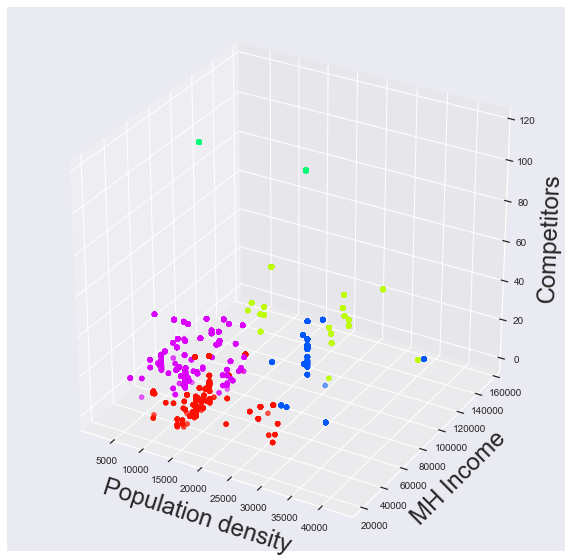

In [156]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
c={}
ax.scatter(df1["Pop./km2"], df1["Median Household Income"], df1["Competitors"], c=df1["Labels"],cmap=cmap1)

ax.set_xlabel('Population density', labelpad=10)
ax.set_ylabel('MH Income', labelpad=10)
ax.set_zlabel('Competitors', labelpad=10)

ax.tick_params(labelsize=10)

plt.show()

#### 2.2 3D scatter diagram

C:\Users\lenor\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


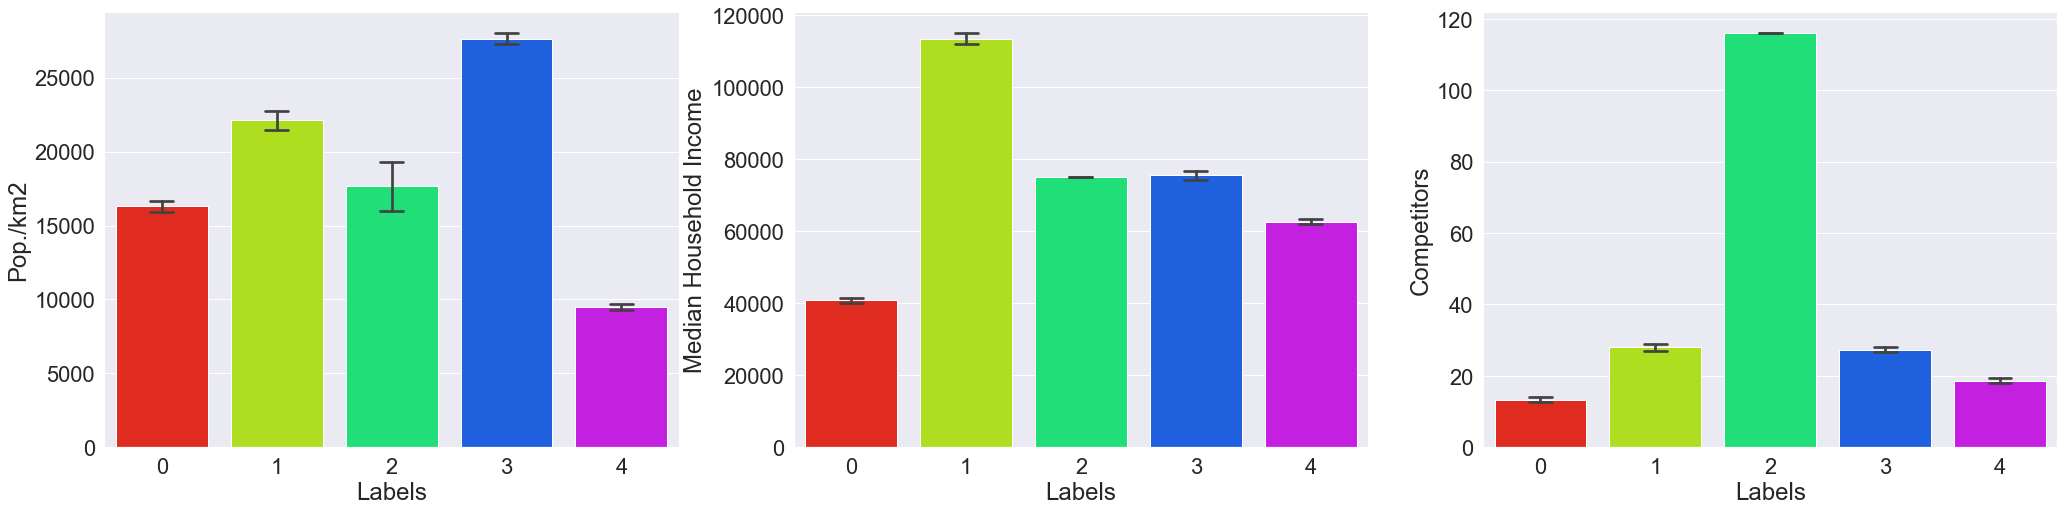

In [157]:
fig=plt.figure(figsize=(35,8))
sns.set(font_scale=2) 
plt.subplot(131)
ax1 = sns.barplot(x="Labels", y="Pop./km2", data=df1, capsize=.2,palette=palette)
plt.subplot(132)
ax2 = sns.barplot(x="Labels", y="Median Household Income", data=df1, capsize=.2,palette=palette)

plt.subplot(133)
ax3 = sns.barplot(x="Labels", y="Competitors", data=df1, capsize=.2,palette=palette)

From the figures, we can see that cluser 5('Lables'==4) have the lowest population density and cluser 1 ('Lables'==0) have the lowest Median Household Income, and they have less Competiors too. 
what's the relationships between Median Household Income, Population density and Competitors? Let's continue analyzing.

### 3. Neighborhoods analysis

In [176]:
# Neighborhoods fature
df_nei=df_res[['Neighborhood','Median Household Income','Pop./km2','Competitors']]
df_nei=df_nei.groupby('Neighborhood').mean()
df_nei.head()


,Median Household Income,Pop./km2,Competitors
Neighborhood,,,
Allerton,37816.894737,12149.0,3
Annadale,66764.200000,2593.0,3
Arrochar,66764.200000,2326.0,4
Arverne,39432.000000,4583.0,1
Astoria,54882.000000,14110.0,35


Let's first take a look at the variables by utilizing a description method.

In [161]:
df_nei.describe()

,Median Household Income,Pop./km2,Competitors
count,265.000000,265.000000,265.000000
mean,59699.984978,13035.127676,10.181132
std,21844.841354,7505.374929,12.168219
min,20334.000000,2326.000000,1.000000
25%,44027.000000,8803.967071,3.000000
50%,57813.625000,14153.791939,5.000000
75%,66764.200000,14353.379074,14.000000
max,155213.000000,42312.000000,116.000000


Then, calculate the Pearson Correlation Coefficient and P-value between variables.

###  Median Household Income VS Competitors

In [162]:
from scipy import stats

pearson_coef, p_value = stats.pearsonr(df_nei['Median Household Income'], df_nei['Competitors'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  


The Pearson Correlation Coefficient is 0.35382224007643276  with a P-value of P = 3.116191157395683e-09


Since the p-value is < 0.001, the correlation between Median Household Income and Competitors is statistically significant, although the linear relationship isn't extremely strong (~0.37)

[]

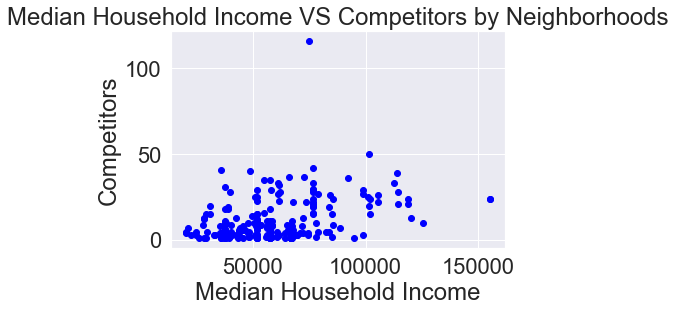

In [163]:
plt.scatter(df_nei['Median Household Income'], df_nei['Competitors'],  color='blue')
plt.xlabel("Median Household Income")
plt.ylabel("Competitors")
plt.title('Median Household Income VS Competitors by Neighborhoods')
plt.plot()

From the plt, we can see that when the neighborhoods have a higher Median Household Income, they have more competitors.
Let's find the neiborhoods which has Median Household Income more than 66764(75%) but CompetitorS less than 10.18(mean).

In [177]:
df_nei['MHI>66764']=df_nei['Median Household Income'].apply(lambda x: x if x>66764 else 0 )
df_nei['Com<11']=df_nei['Competitors'].apply(lambda x: x if x<10.18 else 0)
df_nei.head()

,Median Household Income,Pop./km2,Competitors,MHI>66764,Com<11
Neighborhood,,,,,
Allerton,37816.894737,12149.0,3,0.0,3
Annadale,66764.200000,2593.0,3,66764.2,3
Arrochar,66764.200000,2326.0,4,66764.2,4
Arverne,39432.000000,4583.0,1,0.0,1
Astoria,54882.000000,14110.0,35,0.0,0


###  Population density VS Competitors

In [165]:

pearson_coef, p_value = stats.pearsonr(df_nei['Pop./km2'], df_nei['Competitors'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.40623520501505717  with a P-value of P = 5.953356640995321e-12


<h5>Conclusion:</h5>
Since the p-value is << 0.001, the correlation between Population density and Competitors is statistically significant, although the linear relationship isn't extremely strong (~0.41).

[]

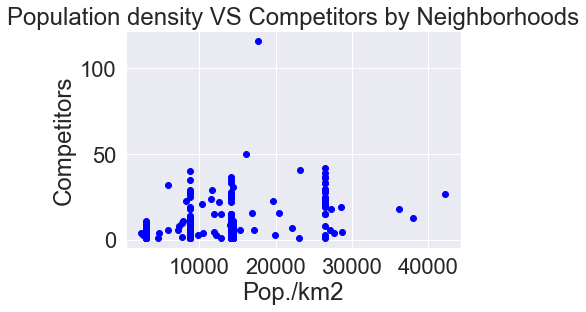

In [175]:
plt.scatter(df_nei['Pop./km2'], df_nei['Competitors'],  color='blue')
plt.xlabel("Pop./km2")
plt.ylabel("Competitors")
plt.title('Population density VS Competitors by Neighborhoods')
plt.plot()

Let's find the neiborhoods which has Population desity more than 14353(75%) but Competitors less than 10(mean).

In [179]:
df_nei['Pop>14353']=df_nei['Pop./km2'].apply(lambda x: x if x>14353 else 0 )
df_nei['Com2<11']=df_nei['Competitors'].apply(lambda x: x if x<11 else 0)
df_nei.head()

,Median Household Income,Pop./km2,Competitors,MHI>66764,Com<11,Pop>14353,Com2<11
Neighborhood,,,,,,,
Allerton,37816.894737,12149.0,3,0.0,3,0.0,3
Annadale,66764.200000,2593.0,3,66764.2,3,0.0,3
Arrochar,66764.200000,2326.0,4,66764.2,4,0.0,4
Arverne,39432.000000,4583.0,1,0.0,1,0.0,1
Astoria,54882.000000,14110.0,35,0.0,0,0.0,0


In [180]:
df2=df_nei.loc[df_nei['MHI>66764']!=0]
df2=df2.loc[df2['Com<11']!=0]
df2=df2.loc[df2['Pop>14353']!=0]
df2=df2.loc[df2['Com2<11']!=0]
df2.drop(['Median Household Income','Pop./km2','Competitors','Com2<11'], axis=1, inplace=True)
df2.reset_index(inplace=True)
df2

,Neighborhood,MHI>66764,Com<11,Pop>14353
0,Edgewater Park,67549.0,8,14353.379074
1,Forest Hills,67881.0,6,15279.000000
2,North Riverdale,78895.0,5,14353.379074
3,Roosevelt Island,98797.0,3,26482.390996
4,Schuylerville,67549.0,4,14353.379074
5,Spuyten Duyvil,67534.0,1,14353.379074
6,Stuyvesant Town,95022.0,1,26482.390996
7,Throgs Neck,67549.0,3,14353.379074


8 neighborhoods are chosen. They have higher Median Household Income and Population density, but number of restaurant is fewer than mean. That means their market consumption capacity is undervalued currently comparing to other neighborhoods.This suggests that there may be rooms for opening new restaurant in those neighborhoods.

In [182]:
df3=df_res.loc[df_res['Neighborhood'].isin(df2['Neighborhood'])]
df3.reset_index(inplace=True, drop=True)
print(df3.shape)
df3.head()

(31, 11)


,Restaurant name,Neighborhood,Borough,Median Household Income,Neighborhood Latitude,Neighborhood Longitude,Pop./km2,Venue Category,Venue Latitude,Venue Longitude,Competitors
0,Muscle Maker Grill_1403,Edgewater Park,Bronx,67549.0,40.821986,-73.813885,14353.379074,American Restaurant,40.819391,-73.817298,8
1,Patricia's of Tremont_1404,Edgewater Park,Bronx,67549.0,40.821986,-73.813885,14353.379074,Italian Restaurant,40.823119,-73.819403,8
2,Green Dragon_1405,Edgewater Park,Bronx,67549.0,40.821986,-73.813885,14353.379074,Asian Restaurant,40.818878,-73.816793,8
3,Tosca Marquee_1406,Edgewater Park,Bronx,67549.0,40.821986,-73.813885,14353.379074,Italian Restaurant,40.819222,-73.817601,8
4,Spoto's Italian Restaurant_1407,Edgewater Park,Bronx,67549.0,40.821986,-73.813885,14353.379074,Italian Restaurant,40.820399,-73.817702,8


There are 31 restaurants in those neighborhoods. Let's visualize them by Folium.

In [183]:
# create map of New York using latitude and longitude values
map_location= folium.Map(location=[latitude, longitude], zoom_start=10)
   
    # add neighborhoods markers to map
for lat, lng, borough, neighborhood in zip(df3['Neighborhood Latitude'], df3['Neighborhood Longitude'], df3['Borough'], df3['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_location)  

# add restaurant markers to map
for lat, lng, restaurant, neighborhood, category in zip(df3['Venue Latitude'], df3['Venue Longitude'], df3['Restaurant name'], df3['Neighborhood'], df3['Venue Category']):
    label = '{}, {}, {}'.format(restaurant, neighborhood, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF0000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_location)  
    
map_location.save('map_location.html')

## 3.Results and Discussion

According to data analysis, we have found 8 neighborhoods where there may be rooms for opening new restaurant. In fact, there are stil many other factors to be considered while deciding a location selection. 

In [184]:

df4=df3[['Restaurant name','Neighborhood','Venue Category']]
df4=df4.loc[df4['Neighborhood']=='Edgewater Park']
df4=df4.groupby(['Neighborhood','Venue Category']).count()
df4=df4.rename(columns={"Restaurant name": "Numbers of restaurants"})
df4

Numbers of restaurants
Neighborhood   Venue Category                             
Edgewater Park American Restaurant                       1
               Asian Restaurant                          1
               Chinese Restaurant                        1
               Italian Restaurant                        4
               Japanese Restaurant                       1

For example, if the owner wants to open a Italian restaurant. Edgewater Park is not a good choice. Because there have been 4 Italian Restaurants in this area. If he does so, the new restaurant may  spend too much time on marketing because of the abundance of competitors around neighborhood. It's better to choose a location from the rest.

### 4.Conclusion

Overall, location selection is a very complicated process. There are many considerations that should be made in the selection.
According to this report, 8 out of 306 neighborhoods are recommended to owners or investors who want to open a restaurant. Although it can't give the exact location, it helps to narrow it down!

### Thank you!